In [201]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sb
import time

#
# To run this code:
# Make sure you have the ml virtualenvironment built and you are working on it.
# Start the jupyter notebook within the virtualenv:
# > workon ml; ipython notebook
#

# Dark style to be visualized easier
sb.set_style("darkgrid")

## Overview
This notebook walks through an example of building a logistic regression classifier. We walk through the specification of the model, how we get the loss function, and provide two methods for optimizing (one we build ourselves, and another using a standard package).

### Background
Logistic regression is defined as follows:

$$p(x) = \frac{1}{1 + exp(\sum_j \beta_j x_j)}$$

$x$ is the input feature vector we'd like to classify.

$\beta$ is a vector of weights, these are the model parameters we will learn from our training data.

$p(x)$ is the resulting probability of $x$ belonging to the positive class.

**Note**: While it is possible to extend logistic regression to perform multi-class classification, this tutorial focused only on the 2 class problem for clarity.

For a more in-depth reference to logistic regression check out this [reference](http://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch12.pdf).

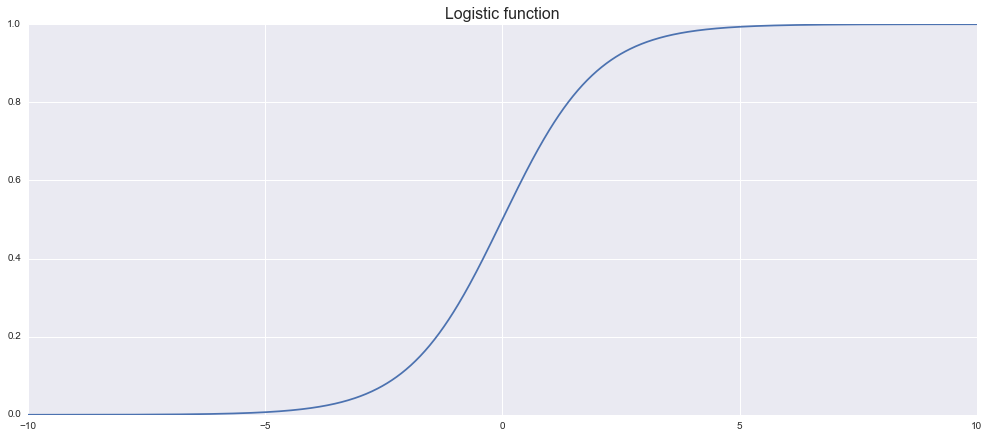

In [202]:
#
# plot the logistic function
#

x = np.linspace(-10, 10, 1000)
# TODO: tweak the parameters and see how the function changes, 
# Can you decrease/increase the slope?
# Can you change the normalization from [0,1] to [2, 10]?
# Can you shift the point at which y = 0.5 from x = 0 to x = 5?
y = 1.0 / (1.0 + np.exp(-x))

fig, ax = plt.subplots(1, figsize=(17,7))
ax.set_title('Logistic function', fontsize=16)

plt.plot(x, y)

In [203]:
#
# Helper methods
#

EPS = 1e-16

def logistic(betas, feature_vectors):
    x = np.array([np.sum(betas * fv) for fv in feature_vectors])
    return 1.0 / (1.0 + np.exp(-x))


def classify(betas, feature_vectors):
    out = logistic(betas, feature_vectors)
    out_class = out >= 0.5
    return out_class


def gen_class(n, mu, sig):
    return np.random.multivariate_normal(mu, np.eye(len(mu)) * sig, n)


# takes an input feature vector and adds a 1 to the end of it
def add_bias(data):
    data1 = np.array(data[:])
    N = len(data1)

    if len(data1.shape) == 1:
        data1 = data1.reshape(1, N)
        data1 = np.append(data1, np.ones((1, 1)), axis=1)
    else:
        data1 = np.append(data1, np.ones((N, 1)), axis=1)
    return data1


def accuracy(data, data_class, betas):
    pred_class = classify(betas, data)
    return np.sum(pred_class == data_class) / (1.0 * len(data_class))


def test_result(beta_learned, n):
    print('\ntest data points from class x1')
    for i in range(n):
        x_test1 = add_bias(gen_class(1, MU1, SIG1))
        print(classify(beta_learned, x_test1)[0], logistic(beta_learned, x_test1)[0])

    print('\ntest data points from class x2')
    for i in range(n):
        x_test2 = add_bias(gen_class(1, MU2, SIG2))
        print(classify(beta_learned, x_test2)[0], logistic(beta_learned, x_test2)[0])

In [204]:
#
# Generate some data
#

# number of points in each class
N = 100

# define parameters for test data
# we're generating from a 2d gaussian distribution, so this is the mean vector and the variance
MU1 = [3, 0]
SIG1 = 1

MU2 = [0, 3]
SIG2 = 1
# TODO: play around with these parameters to see how the classification changes. 
# what happens when the classes are not linearly separable?

# generate 2-d gaussian data with these parameters
X1 = gen_class(N, MU1, SIG1)
X2 = gen_class(N, MU2, SIG2)
data = np.concatenate((X1, X2))

# define the classes
Y1 = np.ones((N, 1)) * 0
Y2 = np.ones((N, 1)) * 1
data_class = np.concatenate((Y1, Y2))

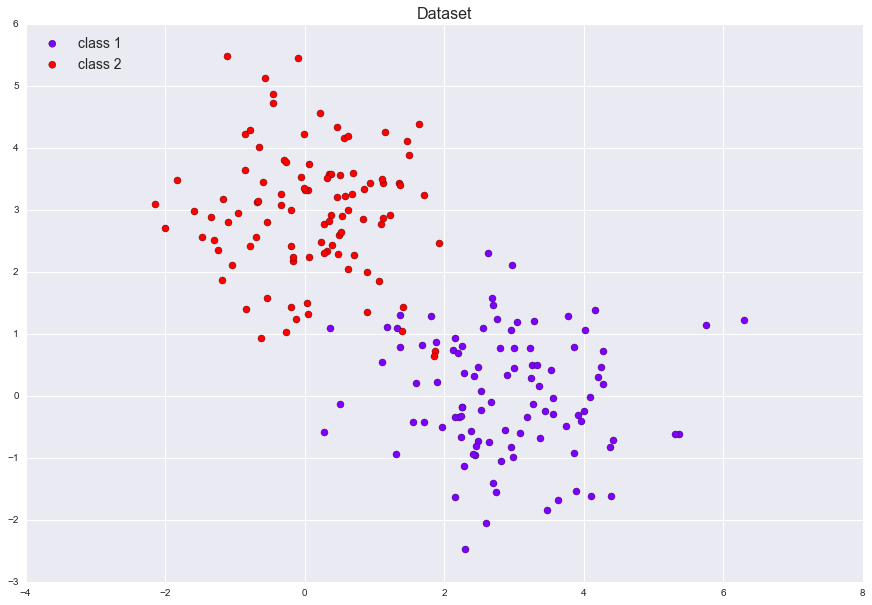

In [205]:
# 
# Do a bunch of stuff here to plot the data
#
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 2))

fig, ax = plt.subplots(1, figsize=(15,10))
ax.set_title('Dataset', fontsize=16)
# plot class 1, then class 2
plt.scatter(X1[:, 0], X1[:, 1], s=50, c=colors[0], label='class 1')
plt.scatter(X2[:, 0], X2[:, 1], s=50, c=colors[1], label='class 2')
legend = ax.legend(loc='upper left', fontsize=14)

### Learning 

We need to build our learning procedure. That is, given our logistic regression model, how can we identify the most appropriate set of weight parameters such that we are able to correctly classify our dataset. To do this, we'll need a bit of math.

Remember, the logistic regressor is defined as:
$$p(x_i) = \frac{1}{1 + exp(\sum_j \beta_j x_{i,j})}$$

This is just plugging a record, $x_i$ into the logistic regression model, where we use $\beta$ to weight each feature in $x_i$ in order to get our class prediction (i.e. probability of being a "positive" example).

To learn the appropriate parameters, we will need to define an objective function (sometimes called a loss function) over which we wish to optimize. The objective defines how we go about scoring a model, so we can quantify how good or bad each set of learned parameters is. Once we have this function, we will discuss how to go about optimizing with respect to $\beta$.

Our goal is to classify data into one of two classes, so we want to identify an objective function that correctly scores models that classify correctly better than models that make mistakes. There are a couple of ways to go about specifying an objective function and learning the weight parameters, but we will walk through one approach using the [binomial likelihood function](https://en.wikipedia.org/wiki/Binomial_distribution).

#### Likelihood function
We will define our likelihood function as follows:

$$like \prod_{i} p_i^{y_i} +  (1 - p_i)^{(1 - y_i)}$$

To learn the appropriate parameters for our model, we can take the derivative of our likelihood function with respect to each $\beta_j$. To simplify the derivative, we first take the logarithm of this function (since maximizing the log-likelihood will also maximize the likelihood and it makes the math much simpler).

$$llike = \sum_{i} y_i log(p_i) + (1 - y_i) log(1 - p_i)$$

Next, we'll take the derivative with respect to each component of $\beta$

$$\frac{\partial}{\partial \beta_j} \sum_{i} y_i log(p_i) + (1 - y_i) log(1 - p_i) = 0$$

After some algebraic manipulation, we find that:

$$\sum_{i} (y_i - p_i) x_{ij} = 0$$

If we expand $p_i$, we can see that it is not possible so solve for $\beta_j$ in a closed form, so we will use an iterative optimization algorithm that approximates the solution by continually moving each $\beta_j$ in the direction of the steepest gradient at each step.


#### Learning algorithm

We can iteratively solve for (approximately) optimal parameters by nudging each $\beta_j$ in the right direction:

$$\beta_j += \alpha \sum_{i} (y_i - p_i) x_{ij}$$

We define a learning rate, $\alpha$, to make sure that we are taking small enough steps (so we don't miss the minimum/maximum). Since we do not know the full form of the function, this ensures that we stay on the right path toward the optimum. If you notice the algorithm switching back and forth between parameter values, it usually means your step size is too large. 

The function defined below puts all of this together.

If you are curious about the full derivation of the maximum likelihood approach, check out this [reference](http://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch12.pdf)

In [206]:
def learn(data, data_class, use_ml=True, learn_iters=4000, alpha=0.1):
    """
    Method for learning logistic regression (LR) parameters

    :param data: Feature vectors over which we'd like to learn, each row is a record, each column is a feature
    :param data_class: Label for the associated record in data
    :param learn_iters: Number of iterations to run through our optimization algorithm
    :param alpha: Gradient step size (i.e. learning rate)
    :return: Vector of learned weighting parameters for LR classifier
    """
    # add bias to input feature vectors
    data = add_bias(data)
    num_rows, num_features = data.shape
    data_class = np.reshape(data_class, (len(data_class),))

    # initialize beta vector (LR Weights) to all zeros
    betas = np.zeros(num_features)  # np.random.random(num_features)

    #
    # Iterate through the optimization
    #
    for iter in range(learn_iters):
        # Given our current beta vector, attempt to classify the data
        # this is our current guess, we'll then compare that to the true labels
        # and attempt to update the beta vector so that we'll be better on the next iteration
        guess = logistic(betas, data)

        for i in range(len(betas)):
            # compute the likelihood of the model
            # we don't actually use this, just print it out for logging
            llike = np.sum(data_class * np.log(guess + EPS) + (1 - data_class) * np.log(1 - guess + EPS))

            if use_ml:
                # if we're using the loglikelihood as our objective function,
                # this is the derivative for beta_i
                diff = np.sum((data_class - guess) * data[:, i])
                betas[i] += alpha * diff
            else:
                # if we're using the squared error as our objective function,
                # this is the derivative of beta_i
                betas[i] += alpha * 2 * np.sum((data_class - guess) * guess * (1 - guess) * data[:, i])
                # note: the constant multiplication by 2 here does not matter. It is technically part of
                # the derivative, but because its constant across any data and parameters, we could leave it
                # out without any affect on the efficacy of the learner.

        if iter % 500 == 0:
            print(iter, betas, llike)

    return betas

In [207]:
#
# Let's do some learning!!
#

# It's finally time to put all of this together and turn it into something useful.
# we'll give our learning algorithm our feature vectors and their corresponding labels
# and get back the learned model parameters.
s = time.time()
betas_learned = learn(data, data_class, alpha=0.05)
e = time.time()

# TODO: play around with the parameters for alpha to see how changing the learning rate influences the convergence
# what if we had higher dimensional data?


print('\nDone learning... {}s'.format(e - s))
print(betas_learned) 
print('\n==============\n')

0 [-6.99975733  7.38878361  0.        ] -138.62943611198904
500 [-2.2564069   2.57670376 -0.41756299] -14.60531097354076
1000 [-2.25640693  2.57670371 -0.41756286] -14.605310973540753
1500 [-2.25640693  2.57670371 -0.41756286] -14.605310973540753
2000 [-2.25640693  2.57670371 -0.41756286] -14.605310973540753
2500 [-2.25640693  2.57670371 -0.41756286] -14.605310973540753
3000 [-2.25640693  2.57670371 -0.41756286] -14.605310973540753
3500 [-2.25640693  2.57670371 -0.41756286] -14.605310973540753

Done learning... 3.8847649097442627s
[-2.25640693  2.57670371 -0.41756286]




In [208]:
#
# reshape data
#
data1 = add_bias(data)

num_rows, num_features = data.shape
data_class1 = np.reshape(data_class, (N * 2,))

print('Accuracy on training data: {}'.format(accuracy(data1, data_class1, betas_learned)))
test_result(betas_learned, 10)

Accuracy on training data: 0.98

test data points from class x1
False 0.002437217250423093
False 0.000988951819738557
False 0.053717172397476684
False 0.0043701741343864725
False 0.0013279747848980725
False 3.6534112592576262e-06
False 0.0045380243601554114
False 0.19085271645007973
False 0.04034393485361608
False 0.0006035593727541348

test data points from class x2
True 0.9999992151275253
True 0.9999957324998614
True 0.9998182771021507
True 0.999947562403218
True 0.8780408361082639
True 0.9993092787443654
True 0.9999949198483975
True 0.9995011357127788
True 0.9998798902264724
True 0.9998846926419231


## Let's use built-in methods to simplify this code!
We build a logistic regression classifier! But what if we don't want to compute our own derivatives? In this case we can simply define our objective function (actually, in this case a loss function which we'll aim to minimize) and use a [standard package](http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.optimize.minimize.html) to do the optimization. 

Of course there are easier ways to accomplish this, the simplest being [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), but the goal for this tutorial is to understand how things work!

To implement our objective function we'll take the log likelihood we defined above and negate it since we're minimizing instead of maximizing.

In [209]:
# 
# First thing we need to do is write a function that can evaluate our objective function.
# The "llike" logic should look familiar, this is the maximum likelihood 
# for binary classification that we defined above. 
#
# We negate the log-likelihood since the scipy function that we're going to use only knows how
# to minimize functions. Since this is a likelihood, we'd actually like to maximize it, but by 
# flipping the sign, we turn this into a loss function!
#
def objective(betas, data, data_class):
    # avoid log(0) = -Inf
    predict = logistic(betas, data)

    # log likelihood function
    llike = -np.sum(data_class * np.log(predict + EPS) + (1 - data_class) * np.log(1 - predict + EPS))
    return llike

In [210]:
#
# Plug our objective function into the standard optimizer and let it do it's thing
#

num_rows, num_features = data1.shape
betas = np.zeros(num_features)  # initialize to a vector of 0's to make sure we have a consistent starting point

s = time.time()
OptimizeResult = minimize(objective, betas, args=(data1, data_class1))
beta_learned_scipy = OptimizeResult.x
e = time.time()
print('\nDone learning... {}s'.format(e - s))

print('BETAS...')
print(beta_learned_scipy)

print('accuracy on training data: {}'.format(accuracy(data1, data_class1, beta_learned_scipy)))


print('test learned classifier')
test_result(beta_learned_scipy, 10)


Done learning... 0.13102412223815918s
BETAS...
[-2.25640671  2.57670399 -0.41756391]
accuracy on training data: 0.98
test learned classifier

test data points from class x1
True 0.772006218480504
False 0.0033659243924731006
False 0.0004762670923950628
False 0.0026076382544881803
False 0.002967820752478501
False 9.897640693598656e-05
False 8.063484532373453e-06
False 0.00014214001379296196
False 0.0036373419344157983
False 8.784110126487105e-06

test data points from class x2
True 0.9908023897675716
True 0.9999307933181871
True 0.9998862135576764
True 0.975230626722229
True 0.9987226848234607
True 0.9932730702049282
True 0.8385535395874137
True 0.9975549054979826
True 0.9646773240040128
True 0.9622362450769102


In [211]:
# Compare the parameters we learned from our own implementation vs the scipy minimizer
# these values should be nearly identical since we're optimizing the same function in both cases
print('learned from our custom code')
print(betas_learned)
print('\nlearned from the scipy optimize method')
print(beta_learned_scipy)

learned from our custom code
[-2.25640693  2.57670371 -0.41756286]

learned from the scipy optimize method
[-2.25640671  2.57670399 -0.41756391]


### Comparison

Both methods seem to provide the same results. This is good, this means we were doing the right thing!
You may also have noticed that our custom code took ~20X longer to execute than the scipy method. 
This is expected since scipy is all highly optimized C code under the covers. They are also probably implementing smarter stopping criteria than we had.


## Tensorflow

So far we've manually implemented gradient descent, and we've used scipy's built-in `minimize()` method. Next, we're going to setup and implement the problem in tensorflow!

Although Tensorflow is often associated with deep learning, it is in fact a generic library that can help you setup and execute complicated mathematical functions and optimization routines. Unlike numpy that executes as normal python code, tensorflow has lazy execution. You first setup your "computational graph", then tensorflow will figure out how to execute over that graph depending on what outputs you are looking for.

In [ ]:
# reset the graph - this allows us to redefine variables and the graph structure 
# (i.e. you can run this cell multiple times without getting an error)
tf.reset_default_graph()

num_rows = data_class1.size
# print('num rows = ', num_rows)
num_dims = data1[0].size


# ----
# create graph
# ----

# weight vector, this is what we're going to learn from our data.
# In tensorflow, things that are learnable are "variables" - as you'll see below, tensorflow will automatically
# update these values as I setup my optimization problem.
betas = tf.get_variable("betas", shape=[1, num_dims], initializer=tf.zeros_initializer())

# The next 2 items are placeholders, these are things that will be defined by input data.
# X is our set of features and y_true is the vector of true labels.
# Placeholders differ from variables as they are just what they sound like - they hold a place in the computational
# graph and wait to get filled in by user defined inputs.
X = tf.placeholder(tf.float32, shape=[num_dims, None], name="data")
y_true = tf.placeholder(tf.float32, shape=[1, None], name="y")

# This is the core of logistic regression: multiplying betas by our input and pushing that into a logistic function
with tf.name_scope('y_pred') as scope:
    y_pred = tf.sigmoid(tf.matmul(betas, X, name="mult"), name="logistic")


# Lastly, we define how to compute our loss function.
# This is the same as what we did above in our `objective()` method - negate the log-likelihood. 
with tf.name_scope('loss') as scope:
    loss = -tf.reduce_sum(tf.multiply(y_true, tf.log(y_pred + EPS), name="positive_loss") + 
                          tf.multiply((1 - y_true), tf.log(1 - y_pred + EPS), name="negative_loss"), axis=1)

# Now we'll tell tensorflow what we want it to do: use gradient descent with the following learning rate to
# minimize our loss function. Because of the computational graph we've defined, Tensorflow knows that 
# it can only change Variables (i.e. it can only minimize this function by updating the betas vector)
opt = tf.train.GradientDescentOptimizer(learning_rate=0.05)
optimizer = opt.minimize(loss)


# -- debug
# loss_parts = tf.multiply(y_true, tf.log(y_pred + EPS)) + tf.multiply((1 - y_true), tf.log(1 - y_pred + EPS))
# print_m = tf.Print(m, [X, betas])
# print_betas = tf.Print(betas, [betas])
# p_loss = tf.Print(loss_parts, [y_pred, y_true])
# p_ypred = tf.Print(y_pred, [m])
# p_ytrue = tf.Print(y_true, [y_true])



In [224]:
NUM_EPOCHS = 4000
show_debug_info = False

writer = tf.summary.FileWriter('./graphs', tf.get_default_graph())
with tf.Session() as sess:
    # this will initialize all of our variables. You can see in our definition above, after this call
    # our betas vector will be set to a vector of 0's
    sess.run(tf.global_variables_initializer())

    if show_debug_info:
        x_, ytrue_, mm_, yp_, loss_, loss1_ = sess.run([X, y_true, m, y_pred, loss_parts, loss],
                                                       feed_dict={X: np.transpose(data1[98:102]), 
                                                                  y_true: np.reshape(data_class1[98:102], (1,4))})

        print('x')
        print(x_)
        print('y true')
        print(ytrue_)
        print('m')
        print(mm_)
        print('ypred')
        print(yp_)
        print('loss vector')
        print(loss_)
        print('loss (summed)')
        print(loss1_)
    
    for i in range(NUM_EPOCHS):
        
        # `feed_dict` is how we feed data into our placeholders defined above.
        # this is our training routine, so we're passing in the data and the true labels so that
        # we can optimize our weights

        _, loss_, betas_ = sess.run([optimizer, loss, betas], 
                                     feed_dict={X: np.transpose(data1), 
                                                y_true: np.reshape(data_class, (1, num_rows))})

        if i % 200 == 0:
#             writer = writer.add_summary(summary, i)
            print('----\n')
            print('[{}] total_loss: {}'.format(i, loss_))
            print('betas:')
            print(betas_)

    tf_learned_betas = sess.run([betas])
writer.close()


# To see the structure of this graph using tensorboard:
# tensorboard --logdir=graphs

----

[0] total_loss: [138.62949]
betas:
[[-6.9997573  7.388784   0.       ]]
----

[200] total_loss: [14.605312]
betas:
[[-2.2562792   2.5768948  -0.41805634]]
----

[400] total_loss: [14.605312]
betas:
[[-2.2564068   2.5767055  -0.41756523]]
----

[600] total_loss: [14.605312]
betas:
[[-2.2564068   2.5767055  -0.41756523]]
----

[800] total_loss: [14.605312]
betas:
[[-2.2564068   2.5767055  -0.41756523]]
----

[1000] total_loss: [14.605312]
betas:
[[-2.2564068   2.5767055  -0.41756523]]
----

[1200] total_loss: [14.605312]
betas:
[[-2.2564068   2.5767055  -0.41756523]]
----

[1400] total_loss: [14.605312]
betas:
[[-2.2564068   2.5767055  -0.41756523]]
----

[1600] total_loss: [14.605312]
betas:
[[-2.2564068   2.5767055  -0.41756523]]
----

[1800] total_loss: [14.605312]
betas:
[[-2.2564068   2.5767055  -0.41756523]]
----

[2000] total_loss: [14.605312]
betas:
[[-2.2564068   2.5767055  -0.41756523]]
----

[2200] total_loss: [14.605312]
betas:
[[-2.2564068   2.5767055  -0.41756523]]
--

In [ ]:
print('learned from tensorflow')
print(tf_learned_betas[0])
print('\nlearned from our custom code')
print(betas_learned)
print('\nlearned from the scipy optimize method')
print(beta_learned_scipy)

print('\naccuracy on training data: {}'.format(accuracy(data1, data_class1, tf_learned_betas)))

print('------------\ntest learned classifier')
test_result(tf_learned_betas, 15)

## Tada!

We learn the (almost) same set of weights across all three methods! Success!